In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Functions

In [4]:
def check_season_data(league, season):
    season_dir = f'{league}_{season}'
    data = []
    for sheet in os.listdir(f'data/{season_dir}'):
        temp = pd.read_csv(f'data/{season_dir}/{sheet}').tail(3)
        data.append([sheet.strip('.csv'), temp['W-L'].values[0]])
    df = pd.DataFrame(data, columns=['Team', 'Record'])
    df['W'] = df['Record'].apply(lambda x: x.split('-')[0]).apply(int)
    df['L'] = df['Record'].apply(lambda x: x.split('-')[1]).apply(int)
    df['W%'] = df['W'] / (df['W'] + df['L'])
    return df.sort_values('W%', ascending=False).drop(['W', 'L'], axis=1)

In [174]:
def calculate_pace(team_df):
    temp = team_df.to_dict(orient='records')
    team_records = {'Team': [temp[i] for i in range(3)
                             if temp[i]['Player'] == 'Total'][0],
                    'Opponent': [temp[i] for i in range(3)
                                 if temp[i]['Player'] == 'Opponents'][0]}
    total_poss = 0
    for side in ['Team']: #, 'Opponent']:
        total_poss += team_records[side]['FGA'] - \
                      team_records[side]['Or'] + \
                      team_records[side]['To'] + \
                      0.44 * team_records[side]['FTA']

    return total_poss, team_records['Team']['MIN'] / 5

In [181]:
def process_team_sheet(team_sheet, season_dir):
    # Initial Process
    df = pd.read_csv(f'data/{season_dir}/{team_sheet}')\
           .drop('W-L', axis=1)
    
    shooting_cols = ['2P', '3P', 'FG', 'FT']
    for col in shooting_cols:
        df[f'{col}M'] = df[col].apply(lambda x: x.split('/')[0])\
                               .apply(int)
        df[f'{col}A'] = df[col].apply(lambda x: x.split('/')[1])\
                               .apply(int)
    df.drop(shooting_cols + [col for col in df.columns
                             if '.1' in col], 
            inplace=True, axis=1)
    df['Dr'] = df['Reb'] - df['Or']
    
    league, season = season_dir.split('_')
    season_dir_ps = f'{league} Play-Offs_{season}'
    df_ps_exist = False
    if team_sheet in os.listdir(f'data/{season_dir_ps}'):
        df_ps_exist = True
        df_ps = pd.read_csv(f'data/{season_dir_ps}/{team_sheet}')\
                  .drop('W-L', axis=1)
        for col in shooting_cols:
            df_ps[f'{col}M'] = df_ps[col].apply(lambda x: x.split('/')[0])\
                                         .apply(int)
            df_ps[f'{col}A'] = df_ps[col].apply(lambda x: x.split('/')[1])\
                                         .apply(int)
        df_ps.drop(shooting_cols + [col for col in df.columns
                                    if '.1' in col], 
                   inplace=True, axis=1)
        df_ps['Dr'] = df_ps['Reb'] - df_ps['Or']
        
    
    # Calculate pace
    team_df = df.tail(3).copy()
    if df_ps_exist:
        team_df_ps = df_ps.tail(3).copy()
        team_df = pd.concat([team_df, team_df_ps])\
                    .drop(['Height', 'Age'], axis=1)\
                    .groupby(['Player', 'Team'])\
                    .sum().reset_index()
    team_poss, team_min = calculate_pace(team_df)
    
    # Get Estimates of players' possessions
    if df_ps_exist:
        df = pd.concat([df, df_ps])\
               .groupby(['Player', 'Height', 'Age', 'Team'])\
               .sum().reset_index()
    df = df[~df['Height'].isna()]
    df['Poss_est'] = df['MIN'] / team_min * team_poss
    
    return df

In [182]:
def process_season_sheets(season, league):
    season_dir = f'{league}_{season}'
    dfs = [process_team_sheet(team_sheet, season_dir)
           for team_sheet in os.listdir(f'data/{season_dir}/')
           if '.csv' in team_sheet]
    df = pd.concat(dfs).reset_index(drop=True)
    df['season'] = season
    return df

## Process Eurocup

In [184]:
league = 'China - CBA'

In [185]:
seasons = list(range(2018, 2022))

In [186]:
# # https://www.proballers.com/basketball/league/177/euroleague/standings/2021
# check_season_data(league, 2021)

In [187]:
# # https://www.proballers.com/basketball/league/177/euroleague/standings/2020
# check_season_data(league, 2020)

In [188]:
# # https://www.proballers.com/basketball/league/177/euroleague/standings/2019
# check_season_data(league, 2019)

In [189]:
# # https://www.proballers.com/basketball/league/177/euroleague/standings/2018
# check_season_data(league, 2018)

In [190]:
# # https://www.proballers.com/basketball/league/177/euroleague/standings/2017
# check_season_data(league, 2017)

In [192]:
df = pd.concat([process_season_sheets(season, league)
                for season in seasons])\
       .reset_index(drop=True)
df.shape

(1430, 29)

<Axes: >

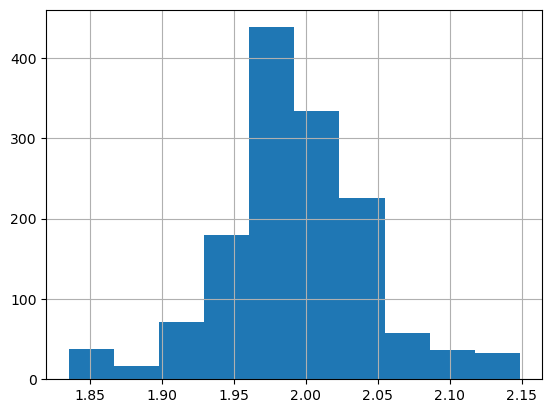

In [193]:
(df['Poss_est'] / df['MIN']).hist()

In [194]:
df.to_csv('proballers_cba_stats.csv', index=False)

In [195]:
del df

### Merge with Synergy

In [35]:
team_dict = {
    'anadolu-efes': 'Anadolu Efes Istanbul', 
    'herbalife-gran-canaria': 'Herbalife Gran Canaria', 
    'khimki-moscow-region': 'Khimki Moscow Region',
    'olympiacos': 'Olympiacos Pireaus', 
    'panathinaikos': 'Panathinaikos Athens', 
    'fc-bayern': 'FC Bayern München',
    'maccabi-playtika-tel-aviv': 'Maccabi Playtika Tel Aviv', 
    'f-c-barcelona': 'FC Barcelona', 
    'zalgiris': 'Zalgiris Kaunas',
    'baskonia': 'Cazoo Baskonia Vitoria-Gasteiz', 
    'darussafaka': 'Darussafaka Tekfen Istanbul', 
    'real-madrid': 'Real Madrid', 
    'fenerbahce': 'Fenerbahce Beko Istanbul',
    'ax-armani-exchange-milano': 'EA7 Emporio Armani Milan', 
    'cska-moscow': 'CSKA Moscow', 
    'buducnost-voli': 'Buducnost VOLI Podgorica',
    'alba-berlin': 'ALBA Berlin', 
    'valencia': 'Valencia Basket', 
    'ldlc-asvel': 'LDLC ASVEL Lyon-Villeurbanne', 
    'zenit-st-petersburg': 'Zenit Saint Petersburg',
    'crvena-zvezda-mts': 'Crvena Zvezda mts', 
    '579': 'Khimki Moscow Region', 
    'monaco': 'AS Monaco Basket', 
    'unics-kazan': 'Unics Kazan'
}

In [441]:
proballers_name_dict = {
    "Johnny O'bryant": "Johnny O'Bryant",
    'Antonio Crocker': 'Tony Crocker',
    'Sam Van Rossom': 'Sam van Rossom',
    'Pere Oriola': 'Pierre Oriola',
    'Dennis Jerome Seeley': 'D.J. Seeley',
    'Iffe Lundberg': 'Gabriel Lundberg',
    'Viatcheslav Zaitsev': 'Vyacheslav Zaytsev',
    'Zan Sisko': 'Zan Mark Sisko',
    'John Di Bartolomeo': 'John DiBartolomeo',
    'Efstratios Perperoglou': 'Stratos Perperoglou',
    'Andrei Vorontsevich': 'Andrey Vorontsevich',
    'Ali Muhammed': 'Bobby Dixon',
    'Dmitry Uzinsky': 'Dmitrii Uzinskii',
    'Egor Vialtsev': 'Egor Vyaltsev',
    'Ibrahima Faye Fall': 'Ibrahima Fall Faye',
    'Vasilis Charalampopoulos': 'Vassilis Charalampopoulos',
    'Vasileios Kavvadas': 'Vassilis Kavvadas',
    'Sandy Cohen III': 'Sandy Cohen',
    'Santi Yusta': 'Santiago Yusta',
    'Miguel Gonzalez Burgos': 'Miguel Gonzalez',
    'Ergi Tirpanci': 'Efe Tirpanci'
}

In [442]:
pb_df = pd.read_csv('proballers_euroleague_stats.csv')
pb_df['Season'] = pb_df['season'].apply(lambda x: f'{x}-{x+1}')
pb_df = pb_df.drop('season', axis=1)
pb_df['Team'] = pb_df['Team'].map(team_dict)
pb_df['Player'] = pb_df['Player'].apply(lambda x: proballers_name_dict.get(x, x))
pb_df.head()

,Player,Height,Age,Pts,Reb,Ast,GP,W-L,MIN,Or,Stl,To,Blk,Fo,Eff,Team,2PM,2PA,3PM,3PA,FGM,FGA,FTM,FTA,Dr,Poss_est,Season
0,Shane Larkin,1m82,26.0,439,77,110,35,22-13,753,12,30,64,3,55,441,Anadolu Efes Istanbul,72,130,66,147,138,277,97,112,65,1388.453956,2018-2019
1,Vasilije Micic,1m96,24.0,459,81,203,37,24-13,1028,9,38,105,2,100,480,Anadolu Efes Istanbul,101,174,66,178,167,352,59,72,72,1895.525454,2018-2019
2,Adrien Moerman,2m02,30.0,443,224,56,37,24-13,1058,47,41,41,11,70,563,Anadolu Efes Istanbul,122,206,55,137,177,343,34,39,177,1950.842344,2018-2019
3,Rodrigue Beaubois,1m95,30.0,333,46,80,35,23-12,702,6,10,37,12,57,286,Anadolu Efes Istanbul,67,138,56,140,123,278,31,34,40,1294.415242,2018-2019
4,Krunoslav Simon,1m98,33.0,349,139,102,37,24-13,898,22,33,49,7,73,445,Anadolu Efes Istanbul,61,103,56,139,117,242,59,70,117,1655.818928,2018-2019


In [450]:
synergy_name_dict = {
    'Konstantinos Sloukas': 'Kostas Sloukas',
    'Deshaun Thomas': 'DeShaun Thomas',
    'Nando de Colo': 'Nando De Colo',
    'Errick Mccollum': 'Errick McCollum',
    'Kostas Mitoglou': 'Konstantinos Mitoglou',
    'Oscar da Silva': 'Oscar Da Silva',
    'Giorgios Papagiannis': 'Georgios Papagiannis',
    'Nico Laprovittola': 'Nicolas Laprovittola',
    'Eleftherios Bochoridis': 'Lefteris Bochoridis',
    'Zan Sisko': 'Zan Mark Sisko',
    'Micheal Eric': 'Michael Eric',
    'Sergey Monya': 'Sergey Monia',
    'Marko Jagodic Kuridza': 'Marko Jagodic-Kuridza',
    'Timothy Abromaitis': 'Tim Abromaitis',
    'OJ Mayo': 'O.J. Mayo',
    'Derrick Walton Jr': 'Derrick Walton',
    'Demarcus Nelson': 'DeMarcus Nelson',
    'Thomas Bray': 'T.J. Bray',
    'Vitaliy Fridzon': 'Vitaly Fridzon',
    'Ibrahima Fall-Faye': 'Ibrahima Fall Faye',
    'Charles Galliou-Loko': 'Charles Galliou',
    'Josep Puerto': 'Joseph Puerto',
    'Giorgos Kalaitzakis': 'Georgios Kalaitzakis',
    'David Kraemer': 'David Kramer',
    'Viacheslav Zaitcev': 'Vyacheslav Zaytsev',
    'Amare Stoudemire': "Amar'e Stoudemire",
    'Andrei Desyatnikov': 'Andrey Desiatnikov',
    'Dmitriy Kadoshnikov': 'Dmitrii Kadoshnikov',
    'Andrey Lopatin': 'Andrei Lopatin',
    'Yonathan Atias': 'Yonatan Atias',
    'Omercan Ilyasoglu': 'Omer Ilyasoglu'
}

In [451]:
synergy_df = pd.read_csv('../data/EuroLeague_offense.csv')
synergy_df = synergy_df[synergy_df['Season'] != '2017-2018']\
             .reset_index(drop=True)
synergy_df['Player'] = synergy_df['Player']\
                       .apply(lambda x: x.strip(' ').replace('  ', ' '))\
                       .apply(lambda x: synergy_name_dict.get(x, x))
synergy_df.head()

,Player,Team,Season,GP,FGM,FGA,Catch and Shoot_FGM,Catch and Shoot_FGA,Catch and Shoot_FG%,Catch and Shoot_FGA%,At Rim_FGM,At Rim_FGA,At Rim_FG%,At Rim_FGA%,Long (3 point jump shots)_FGM,Long (3 point jump shots)_FGA,Long (3 point jump shots)_FG%,Long (3 point jump shots)_FGA%,All Jump Shots off the Dribble_FGM,All Jump Shots off the Dribble_FGA,All Jump Shots off the Dribble_FG%,All Jump Shots off the Dribble_FGA%,Isolation_Poss,Isolation_PPP,P&R Ball Handler_Poss,P&R Ball Handler_PPP,Post-Up_Poss,Post-Up_PPP,P&R Roll Man_Poss,P&R Roll Man_PPP,Spot Up_Poss,Spot Up_PPP,Off Screen_Poss,Off Screen_PPP,Hand Off_Poss,Hand Off_PPP,Cut_Poss,Cut_PPP,Offensive Rebounds_Poss,Offensive Rebounds_PPP,Transition_Poss,Transition_PPP,Overall_Poss,Isolation_Poss%,P&R Ball Handler_Poss%,Post-Up_Poss%,P&R Roll Man_Poss%,Spot Up_Poss%,Off Screen_Poss%,Hand Off_Poss%,Cut_Poss%,Offensive Rebounds_Poss%,Transition_Poss%,Pick and Rolls Including Passes_Poss,Isolations Including Passes_Poss,Post-Ups Including Passes_Poss,P&R Ball Handler_End_Rt
0,Brandon Davies,Zalgiris Kaunas,2018-2019,34,176.0,315.0,19.0,41.0,0.463415,0.130159,137.0,215.0,0.637209,0.682540,0.0,0.0,0.000000,0.000000,0.0,5.0,0.000000,0.015873,9.0,1.111,0.0,0.000,95.0,0.979,108.0,1.139,21.0,0.286,11.0,0.909,1.0,2.00,93.0,1.022,50.0,1.440,28.0,1.321,416.0,0.021635,0.000000,0.228365,0.259615,0.050481,0.026442,0.002404,0.223558,0.120192,0.067308,0.0,9.0,125.0,0.000000
1,Nate Wolters,Zalgiris Kaunas,2018-2019,28,132.0,257.0,15.0,34.0,0.441176,0.132296,51.0,87.0,0.586207,0.338521,25.0,68.0,0.367647,0.264591,14.0,44.0,0.318182,0.171206,32.0,1.063,135.0,0.948,0.0,0.000,0.0,0.000,46.0,1.261,4.0,1.750,10.0,0.80,8.0,1.500,4.0,1.000,47.0,1.021,286.0,0.111888,0.472028,0.000000,0.000000,0.160839,0.013986,0.034965,0.027972,0.013986,0.164336,276.0,40.0,0.0,0.489130
2,Marius Grigonis,Zalgiris Kaunas,2018-2019,34,88.0,189.0,29.0,59.0,0.491525,0.312169,31.0,53.0,0.584906,0.280423,34.0,77.0,0.441558,0.407407,8.0,27.0,0.296296,0.142857,18.0,0.500,69.0,0.913,12.0,1.000,0.0,0.000,73.0,1.288,33.0,1.273,20.0,1.10,2.0,1.000,2.0,0.000,20.0,1.000,249.0,0.072289,0.277108,0.048193,0.000000,0.293173,0.132530,0.080321,0.008032,0.008032,0.080321,141.0,19.0,20.0,0.489362
3,Aaron White,Zalgiris Kaunas,2018-2019,34,97.0,187.0,19.0,44.0,0.431818,0.235294,70.0,116.0,0.603448,0.620321,14.0,42.0,0.333333,0.224599,4.0,12.0,0.333333,0.064171,2.0,1.000,0.0,0.000,22.0,1.091,22.0,1.273,88.0,1.000,3.0,0.667,1.0,0.00,49.0,1.163,17.0,0.941,31.0,1.516,235.0,0.008511,0.000000,0.093617,0.093617,0.374468,0.012766,0.004255,0.208511,0.072340,0.131915,0.0,2.0,26.0,0.000000
4,Arturas Milaknis,Zalgiris Kaunas,2018-2019,34,75.0,186.0,50.0,122.0,0.409836,0.655914,10.0,21.0,0.476190,0.112903,60.0,144.0,0.416667,0.774194,11.0,29.0,0.379310,0.155914,1.0,0.000,10.0,0.300,0.0,0.000,0.0,0.000,68.0,1.015,76.0,1.105,25.0,1.24,6.0,1.333,2.0,0.000,15.0,1.200,203.0,0.004926,0.049261,0.000000,0.000000,0.334975,0.374384,0.123153,0.029557,0.009852,0.073892,15.0,1.0,0.0,0.666667


In [454]:
df = synergy_df.merge(pb_df,
                      on=['Season', 'Team', 'Player'],
                      how='left')

In [455]:
df[df['Eff'].isna()].sort_values('Overall_Poss', ascending=False)

,Player,Team,Season,GP_x,FGM_x,FGA_x,Catch and Shoot_FGM,Catch and Shoot_FGA,Catch and Shoot_FG%,Catch and Shoot_FGA%,At Rim_FGM,At Rim_FGA,At Rim_FG%,At Rim_FGA%,Long (3 point jump shots)_FGM,Long (3 point jump shots)_FGA,Long (3 point jump shots)_FG%,Long (3 point jump shots)_FGA%,All Jump Shots off the Dribble_FGM,All Jump Shots off the Dribble_FGA,All Jump Shots off the Dribble_FG%,All Jump Shots off the Dribble_FGA%,Isolation_Poss,Isolation_PPP,P&R Ball Handler_Poss,P&R Ball Handler_PPP,Post-Up_Poss,Post-Up_PPP,P&R Roll Man_Poss,P&R Roll Man_PPP,Spot Up_Poss,Spot Up_PPP,Off Screen_Poss,Off Screen_PPP,Hand Off_Poss,Hand Off_PPP,Cut_Poss,Cut_PPP,Offensive Rebounds_Poss,Offensive Rebounds_PPP,Transition_Poss,Transition_PPP,Overall_Poss,Isolation_Poss%,P&R Ball Handler_Poss%,Post-Up_Poss%,P&R Roll Man_Poss%,Spot Up_Poss%,Off Screen_Poss%,Hand Off_Poss%,Cut_Poss%,Offensive Rebounds_Poss%,Transition_Poss%,Pick and Rolls Including Passes_Poss,Isolations Including Passes_Poss,Post-Ups Including Passes_Poss,P&R Ball Handler_End_Rt,Height,Age,Pts,Reb,Ast,GP_y,W-L,MIN,Or,Stl,To,Blk,Fo,Eff,2PM,2PA,3PM,3PA,FGM_y,FGA_y,FTM,FTA,Dr,Poss_est


## Create New Features

In [456]:
situations = ['Pick and Rolls Including Passes',
              'Isolations Including Passes',
              'Post-Ups Including Passes']

In [457]:
for situation in situations:
    df[f'{situation}_On_Court%'] = df[f'{situation}_Poss'] / \
                                   df['Poss_est']
    print(situation, 
          df[f'{situation}_On_Court%'].max(),
          df[f'{situation}_On_Court%'].min())
df.head()

Pick and Rolls Including Passes 0.8143809093232166 0.0
Isolations Including Passes 0.28908136847775096 0.0
Post-Ups Including Passes 0.17436159279406663 0.0


,Player,Team,Season,GP_x,FGM_x,FGA_x,Catch and Shoot_FGM,Catch and Shoot_FGA,Catch and Shoot_FG%,Catch and Shoot_FGA%,At Rim_FGM,At Rim_FGA,At Rim_FG%,At Rim_FGA%,Long (3 point jump shots)_FGM,Long (3 point jump shots)_FGA,Long (3 point jump shots)_FG%,Long (3 point jump shots)_FGA%,All Jump Shots off the Dribble_FGM,All Jump Shots off the Dribble_FGA,All Jump Shots off the Dribble_FG%,All Jump Shots off the Dribble_FGA%,Isolation_Poss,Isolation_PPP,P&R Ball Handler_Poss,P&R Ball Handler_PPP,Post-Up_Poss,Post-Up_PPP,P&R Roll Man_Poss,P&R Roll Man_PPP,Spot Up_Poss,Spot Up_PPP,Off Screen_Poss,Off Screen_PPP,Hand Off_Poss,Hand Off_PPP,Cut_Poss,Cut_PPP,Offensive Rebounds_Poss,Offensive Rebounds_PPP,Transition_Poss,Transition_PPP,Overall_Poss,Isolation_Poss%,P&R Ball Handler_Poss%,Post-Up_Poss%,P&R Roll Man_Poss%,Spot Up_Poss%,Off Screen_Poss%,Hand Off_Poss%,Cut_Poss%,Offensive Rebounds_Poss%,Transition_Poss%,Pick and Rolls Including Passes_Poss,Isolations Including Passes_Poss,Post-Ups Including Passes_Poss,P&R Ball Handler_End_Rt,Height,Age,Pts,Reb,Ast,GP_y,W-L,MIN,Or,Stl,To,Blk,Fo,Eff,2PM,2PA,3PM,3PA,FGM_y,FGA_y,FTM,FTA,Dr,Poss_est,Pick and Rolls Including Passes_On_Court%,Isolations Including Passes_On_Court%,Post-Ups Including Passes_On_Court%
0,Brandon Davies,Zalgiris Kaunas,2018-2019,34,176.0,315.0,19.0,41.0,0.463415,0.130159,137.0,215.0,0.637209,0.682540,0.0,0.0,0.000000,0.000000,0.0,5.0,0.000000,0.015873,9.0,1.111,0.0,0.000,95.0,0.979,108.0,1.139,21.0,0.286,11.0,0.909,1.0,2.00,93.0,1.022,50.0,1.440,28.0,1.321,416.0,0.021635,0.000000,0.228365,0.259615,0.050481,0.026442,0.002404,0.223558,0.120192,0.067308,0.0,9.0,125.0,0.000000,2m08,27.0,483,186,67,34,16-18,808,62,33,65,15,99,539,176,315,0,0,176,315,131,172,124,1458.592396,0.000000,0.006170,0.085699
1,Nate Wolters,Zalgiris Kaunas,2018-2019,28,132.0,257.0,15.0,34.0,0.441176,0.132296,51.0,87.0,0.586207,0.338521,25.0,68.0,0.367647,0.264591,14.0,44.0,0.318182,0.171206,32.0,1.063,135.0,0.948,0.0,0.000,0.0,0.000,46.0,1.261,4.0,1.750,10.0,0.80,8.0,1.500,4.0,1.000,47.0,1.021,286.0,0.111888,0.472028,0.000000,0.000000,0.160839,0.013986,0.034965,0.027972,0.013986,0.164336,276.0,40.0,0.0,0.489130,1m93,27.0,314,79,106,28,12-16,628,8,23,41,0,61,344,107,190,25,68,132,258,25,36,71,1133.658446,0.243460,0.035284,0.000000
2,Marius Grigonis,Zalgiris Kaunas,2018-2019,34,88.0,189.0,29.0,59.0,0.491525,0.312169,31.0,53.0,0.584906,0.280423,34.0,77.0,0.441558,0.407407,8.0,27.0,0.296296,0.142857,18.0,0.500,69.0,0.913,12.0,1.000,0.0,0.000,73.0,1.288,33.0,1.273,20.0,1.10,2.0,1.000,2.0,0.000,20.0,1.000,249.0,0.072289,0.277108,0.048193,0.000000,0.293173,0.132530,0.080321,0.008032,0.008032,0.080321,141.0,19.0,20.0,0.489362,1m98,24.0,296,73,66,34,16-18,693,7,20,46,0,87,302,54,112,34,77,88,189,86,92,66,1250.995706,0.112710,0.015188,0.015987
3,Aaron White,Zalgiris Kaunas,2018-2019,34,97.0,187.0,19.0,44.0,0.431818,0.235294,70.0,116.0,0.603448,0.620321,14.0,42.0,0.333333,0.224599,4.0,12.0,0.333333,0.064171,2.0,1.000,0.0,0.000,22.0,1.091,22.0,1.273,88.0,1.000,3.0,0.667,1.0,0.00,49.0,1.163,17.0,0.941,31.0,1.516,235.0,0.008511,0.000000,0.093617,0.093617,0.374468,0.012766,0.004255,0.208511,0.072340,0.131915,0.0,2.0,26.0,0.000000,2m05,26.0,280,142,23,34,16-18,831,35,12,28,7,71,327,83,145,14,42,97,187,72,91,107,1500.111734,0.000000,0.001333,0.017332
4,Arturas Milaknis,Zalgiris Kaunas,2018-2019,34,75.0,186.0,50.0,122.0,0.409836,0.655914,10.0,21.0,0.476190,0.112903,60.0,144.0,0.416667,0.774194,11.0,29.0,0.379310,0.155914,1.0,0.000,10.0,0.300,0.0,0.000,0.0,0.000,68.0,1.015,76.0,1.105,25.0,1.24,6.0,1.333,2.0,0.000,15.0,1.200,203.0,0.004926,0.049261,0.000000,0.000000,0.334975,0.374384,0.123153,0.029557,0.009852,0.073892,15.0,1.0,0.0,0.666667,1m95,32.0,239,49,30,34,16-18,770,10,22,23,2,57,203,15,42,60,144,75,186,29,34,39,1389.995229,0.010791,0.000719,0.000000


## Save

In [458]:
df.to_csv('../euroleague_offense_plus_pb.csv', index=False)